# Fraudelent Activities Detection

## Goal<br>
### Build a machine learning model to predict the probability that the first transaction of a new user is fraudulent.<br>
#### 1. For each user, determine her country based on the numeric IP address.<br>
#### 2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.<br>
#### 3. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?<br>
#### 4. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?


In [1]:
import pandas as pd
import numpy as np

In [2]:
# each new user's first transaction
data = pd.read_csv(r'C:\Users\lshen\Downloads\Fraud\Fraud_Data.csv')
ip = pd.read_csv(r'C:\Users\lshen\Downloads\Fraud\IpAddress_to_Country.csv')

In [3]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [5]:
data.shape

(151112, 11)

In [6]:
# check if there is any duplicate values
len(data.user_id.unique())

151112

In [7]:
data.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [8]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## 1. Determine the country based on ip

In [9]:
# create country with NA values
data['country'] = np.nan

In [10]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,NaN
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,NaN
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,NaN
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,NaN


In [11]:
# look up the country in ip table and update country value
# some ip_addres don't have corresponding values, check if length is 0, then remain nan value
for i in range(len(data)):
    c = ip[(ip.lower_bound_ip_address <=data.ip_address[i])&(ip.upper_bound_ip_address>=data.ip_address[i])].country
    if len(c) == 1:
        data.loc[i,'country'] = c.iloc[0]

In [12]:
data.country.value_counts(dropna = False)

United States                           58049
NaN                                     21966
China                                   12038
Japan                                    7306
United Kingdom                           4490
Korea Republic of                        4162
Germany                                  3646
France                                   3161
Canada                                   2975
Brazil                                   2961
Italy                                    1944
Australia                                1844
Netherlands                              1680
Russian Federation                       1616
India                                    1310
Taiwan; Republic of China (ROC)          1237
Mexico                                   1121
Sweden                                   1090
Spain                                    1027
South Africa                              838
Switzerland                               785
Poland                            

## 2. Build a Model

### 2.1 Feature Engineering 

#### 2.1.1  I have a hypothesis that if it's a very short time between signup and purchase, there is a large chance that it's a fraud. So change the data type to datetime and also create a new feature of time difference

In [13]:
data['signup_time']=pd.to_datetime(data.signup_time)
data['purchase_time']=pd.to_datetime(data.purchase_time)

In [14]:
data.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
country                   object
dtype: object

In [15]:
data['purchase_signup_diff'] =  (data.purchase_time - data.signup_time)/np.timedelta64(1,'s')

In [16]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


#### 2.1.2 Hypothesis: if multiple users use the same device, might have a larger chance of fraud.<br>
Create a feature with total number of occurance of this device

In [17]:
data['device_occ'] = np.nan

In [18]:
counts = data.device_id.value_counts()

In [19]:
for i in range(len(data)):
    data.loc[i,'device_occ'] = counts[data.loc[i,'device_id']]

In [20]:
data.device_occ.head()

0     1.0
1     1.0
2    12.0
3     1.0
4     1.0
Name: device_occ, dtype: float64

#### 2.1.3 Hypothesis: if multiple users use same ip address, might have a larger chance of fraud.<br>
Create a feature with counts of ip address

In [21]:
data['ip_occ'] = np.nan

In [22]:
counts_ip = data.ip_address.value_counts()

In [23]:
for i in range(len(data)):
    data.loc[i,'ip_occ'] = counts_ip[data.loc[i,'ip_address']]

In [24]:
data.ip_occ.head()

0     1.0
1     1.0
2    12.0
3     1.0
4     1.0
Name: ip_occ, dtype: float64

#### 2.1.4 Day of week

In [25]:
data['signup_dayofweek'] = data.signup_time.dt.dayofweek
data['purchase_dayofweek'] = data.purchase_time.dt.dayofweek

#### 2.1.5 Week of year

In [26]:
data['signup_weekofyear'] = data.signup_time.dt.week
data['purchase_weekofyear'] = data.purchase_time.dt.week

In [27]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_occ,ip_occ,signup_dayofweek,purchase_dayofweek,signup_weekofyear,purchase_weekofyear
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1.0,1.0,1,5,9,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1.0,1.0,6,0,23,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12.0,12.0,3,3,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,492085.0,1.0,1.0,1,0,18,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1.0,1.0,1,2,30,37


#### 2.1.6 replace country NA values with str

In [28]:
data.country.fillna('Not_found', inplace=True)

In [29]:
data.isnull().sum()

user_id                 0
signup_time             0
purchase_time           0
purchase_value          0
device_id               0
source                  0
browser                 0
sex                     0
age                     0
ip_address              0
class                   0
country                 0
purchase_signup_diff    0
device_occ              0
ip_occ                  0
signup_dayofweek        0
purchase_dayofweek      0
signup_weekofyear       0
purchase_weekofyear     0
dtype: int64

#### 2.1.7 keep top 50 countries, name the rest "Others" 

In [30]:
# get the top 50 countries
country_counts = data.country.value_counts().head(50)

In [31]:
for i in range(len(data)):
    if data.loc[i,'country'] not in country_counts:
        data.loc[i,'country'] = 'Others'

In [32]:
data.country.value_counts()

United States                      58049
Not_found                          21966
China                              12038
Japan                               7306
United Kingdom                      4490
Korea Republic of                   4162
Others                              4050
Germany                             3646
France                              3161
Canada                              2975
Brazil                              2961
Italy                               1944
Australia                           1844
Netherlands                         1680
Russian Federation                  1616
India                               1310
Taiwan; Republic of China (ROC)     1237
Mexico                              1121
Sweden                              1090
Spain                               1027
South Africa                         838
Switzerland                          785
Poland                               729
Argentina                            661
Indonesia       

In [33]:
data.country.nunique()

51

#### Create dummy values for categorical columns

In [34]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_occ,ip_occ,signup_dayofweek,purchase_dayofweek,signup_weekofyear,purchase_weekofyear
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1.0,1.0,1,5,9,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1.0,1.0,6,0,23,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12.0,12.0,3,3,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Not_found,492085.0,1.0,1.0,1,0,18,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1.0,1.0,1,2,30,37


In [35]:
source_dummies = pd.get_dummies(data.source,prefix = 'source_').iloc[:,1:]
browser_dummies = pd.get_dummies(data.browser,prefix = 'browser_').iloc[:,1:]
sex_dummies = pd.get_dummies(data.sex,prefix = 'sex_').iloc[:,1:]
country_dummies = pd.get_dummies(data.country,prefix = 'country_').iloc[:,1:]

In [36]:
data = pd.concat([data, source_dummies,browser_dummies, sex_dummies,country_dummies],axis = 1)

In [37]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country__Sweden,country__Switzerland,country__Taiwan; Republic of China (ROC),country__Thailand,country__Turkey,country__Ukraine,country__United Kingdom,country__United States,country__Venezuela,country__Viet Nam
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,0,0,0,0,0,0,0,1,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,0,0,0,0,0,0,0,1,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,0,0,0,0,0,0,0,1,0,0


In [38]:
len(data.columns)

76

In [39]:
feature_col = []

In [40]:
for i in range(12,len(data.columns)):
    feature_col.append(data.columns[i])

#### 2.1.8 Feature columns

In [41]:
feature_col.append('purchase_value')

In [42]:
len(feature_col)

65

### 2.2 Build Model

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [44]:
X = data[feature_col]
y = data['class']

In [45]:
X.head()

,purchase_signup_diff,device_occ,ip_occ,signup_dayofweek,purchase_dayofweek,signup_weekofyear,purchase_weekofyear,source__Direct,source__SEO,browser__FireFox,...,country__Switzerland,country__Taiwan; Republic of China (ROC),country__Thailand,country__Turkey,country__Ukraine,country__United Kingdom,country__United States,country__Venezuela,country__Viet Nam,purchase_value
0,4506682.0,1.0,1.0,1,5,9,16,0,1,0,...,0,0,0,0,0,0,0,0,0,34
1,17944.0,1.0,1.0,6,0,23,24,0,0,0,...,0,0,0,0,0,0,1,0,0,16
2,1.0,12.0,12.0,3,3,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,15
3,492085.0,1.0,1.0,1,0,18,19,0,1,0,...,0,0,0,0,0,0,0,0,0,44
4,4361461.0,1.0,1.0,1,2,30,37,0,0,0,...,0,0,0,0,0,0,1,0,0,39


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [47]:
print (X.shape, y.shape,X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(151112, 65) (151112,) (105778, 65) (45334, 65) (105778,) (45334,)


In [48]:
rf = RandomForestClassifier(n_jobs=50,random_state=0)

In [49]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=50,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [50]:
y_pred = rf.predict(X_test)

In [51]:
rf.predict_proba(X_test)

array([[0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [52]:
# calculate the accuracy of the trained classifier
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred))

0.9574491551594829


#### 2.2.2 Cross validation

In [53]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [54]:
kf = KFold(n_splits=10,random_state = 0)
modelCV = RandomForestClassifier()

In [55]:
scoring = 'accuracy'

In [56]:
results = cross_val_score(modelCV, X_train, y_train, cv = kf, scoring = scoring)

In [57]:
print ('10-fold cross validation average accuracy: {}'.format(results.mean()))

10-fold cross validation average accuracy: 0.9546692324782885


The avg accuacy score is very close to model

#### 2.2.3 Confusion Matrix, ROC curve--Evaluate false positive and false negative

In [58]:
from sklearn.metrics import confusion_matrix

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred)
print (conf_matrix)

[[41098    79]
 [ 1850  2307]]


In [60]:
# same as above
pd.crosstab(y_test, y_pred,rownames=['Actual Value'], colnames=['Predicted Value'])

Predicted Value,0,1
Actual Value,,
0,41098,79
1,1850,2307


There are 79 false positive and 1850 false negative

ROC(Receiver Operating Characteristic) Curve typically feature true positive rate on the Y axis and false positive rate on the X axis. This means that the top left corner of the plot is the "ideal" point - a false positive rate of zero, and true positive is rate of one. It does mean that a larger area under the curve(AUC) is usually better.<br>
The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.<br>
ROC curves are typically used in binary classification to study the output of a classifier. 

In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [62]:
rf_roc_auc_score = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

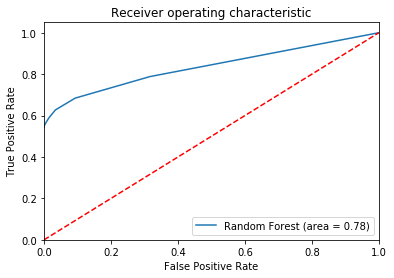

In [63]:
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

Based on the ROC, if we care about minimising false positive, we would choose a cutoff that would give us about 0.5 true positive rate. <br>
However if we care about maximizing the true positive, we will have to decrease the cut-off. This way, we will classify more events as "1"-- true positive goes up, meanwhile, false positive will also go up.<br>
In this case, I believe we should increase the true positive rate. Because we want to catch more fraud, just to be cautious. 

#### 2.2.4 Feature Importance

In [71]:
#get a score telling how importance each feature is in classifying
feature_importance = pd.DataFrame(list(zip(X.columns,rf.feature_importances_)), columns = ['feature','score'])

In [74]:
feature_importance.sort_values(by = 'score', ascending = False)

,feature,score
1,device_occ,0.242327
2,ip_occ,0.141782
6,purchase_weekofyear,0.135216
0,purchase_signup_diff,0.124294
5,signup_weekofyear,0.099185
64,purchase_value,0.071053
4,purchase_dayofweek,0.037560
3,signup_dayofweek,0.035797
13,sex__M,0.011800
8,source__SEO,0.009839


Observations:<br>
- Using the same device and ip address are the most important ones that detect a fraud.<br>
- Sign up/Purchse time difference<br>
- Purchase value<br>